In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline


In [25]:
def sigmoid(x):
    """
    计算x的sigmoid
    
    参数：
    x 是一个值 或者一个数列
    
    返回：
     s -- simoid(x)
     
    """
    s = 1.0/(1+1/np.exp(x))
    return s

In [2]:
#我们创造一个线性不可分的数据 等下用神经网络去预测
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # 样本数量
    N = int(m/2) # 每个类别的样本量
    D = 2 # 维度数
    X = np.zeros((m,D)) # 初始化X
    Y = np.zeros((m,1), dtype='uint8') # 初始化Y
    a = 4 # 花儿的最大长度

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y


X, Y = load_planar_dataset()


In [13]:
Y.shape

(1, 400)

In [14]:
X.shape

(2, 400)

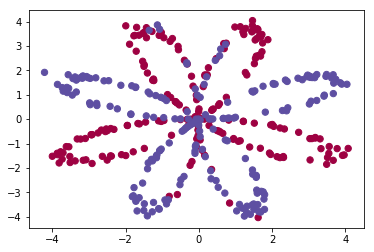

In [9]:
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral)

In [10]:
#定义一些参数
def layer_sizes(X,Y):
    #输入层单元个数
    n_x = X.shape[0] 
    #神经元个数
    n_h = 4
    #输出层单元个数
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)


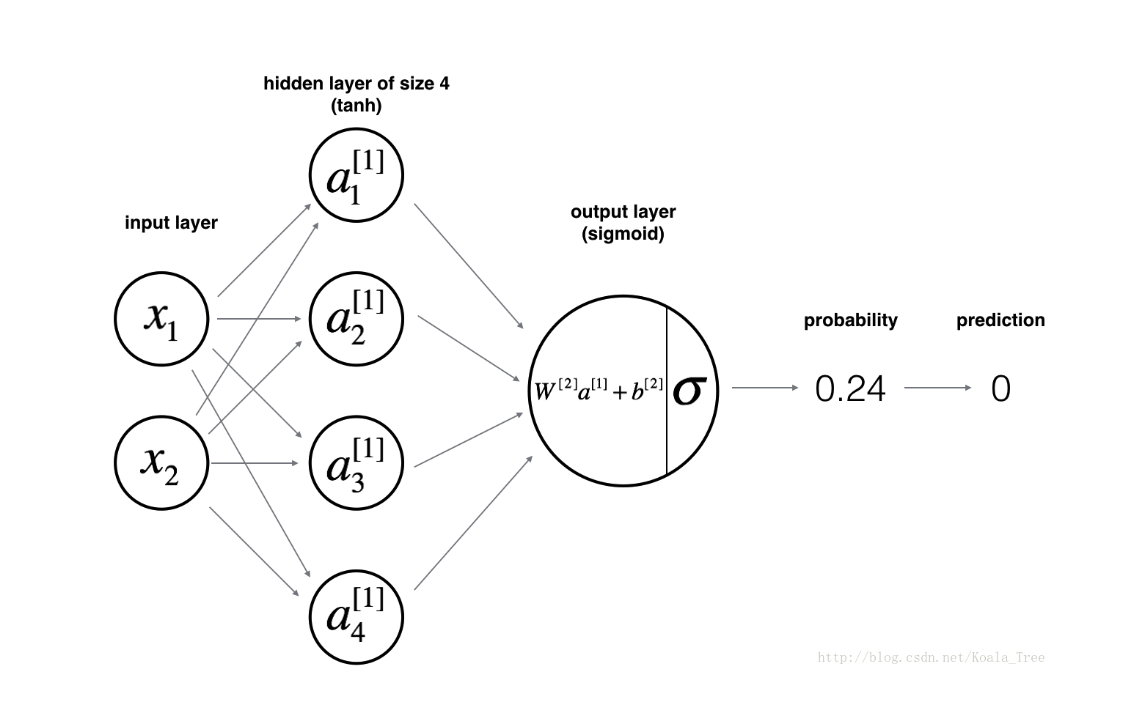

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    
    #随机化种子
    np.random.seed(2) 

    #随机初始化参数
    W1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


In [12]:
#开始前向传播
def forward_propagation(X, parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    #tanh激励函数多用于处理线性不可分问题
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2 
    A2 = sigmoid(Z2)
    

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache


In [17]:
#开始计算误差（成本函数）
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    #multiply 用于矩阵对应位置相乘,这个时候就不用在意乘法交换律了
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), (1-Y))
    cost = -(1.0/m)*np.sum(logprobs)

    cost = np.squeeze(cost)     
    assert(isinstance(cost, float))

    return cost


In [18]:
#反向传播
def backward_propagation(parameters, cache, X, Y):
    
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    dZ2 = A2 - Y
    dW2 = 1.0/m*np.dot(dZ2, A1.T)
    db2 = 1.0/m*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2)*(1-np.power(A1, 2))
    dW1 = 1.0/m*np.dot(dZ1, X.T)
    db1 = 1.0/m*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads


In [19]:
#梯度下降，更新参数
def update_parameters(parameters, grads, learning_rate = 1.2):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


In [20]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters


In [21]:
def predict(parameters, X):
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions


Cost after iteration 0: 1.127380
Cost after iteration 1000: 0.288553
Cost after iteration 2000: 0.276386
Cost after iteration 3000: 0.268077
Cost after iteration 4000: 0.263069
Cost after iteration 5000: 0.259617
Cost after iteration 6000: 0.257070
Cost after iteration 7000: 0.255105
Cost after iteration 8000: 0.253534
Cost after iteration 9000: 0.252245


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

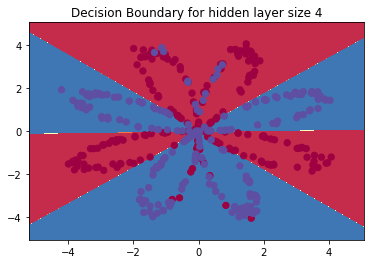

In [36]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
h = 0.01
#定义网格
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#预测
Z = predict(parameters,np.c_[xx.ravel(), yy.ravel()].T)
Z = Z.reshape(xx.shape)
#置信区间
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X[0, :], X[1, :], c= Y[0], s=40, cmap=plt.cm.Spectral)
plt.title("Decision Boundary for hidden layer size " + str(4))
